In [1]:
import pandas as pd


In [2]:
pip install ucimlrepo

In [3]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
online_retail = fetch_ucirepo(id=352)

# data (as pandas dataframes)
X = online_retail.data.features
y = online_retail.data.targets

# metadata
print(online_retail.metadata)

# variable information
print(online_retail.variables)


{'uci_id': 352, 'name': 'Online Retail', 'repository_url': 'https://archive.ics.uci.edu/dataset/352/online+retail', 'data_url': 'https://archive.ics.uci.edu/static/public/352/data.csv', 'abstract': 'This is a transactional data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.', 'area': 'Business', 'tasks': ['Classification', 'Clustering'], 'characteristics': ['Multivariate', 'Sequential', 'Time-Series'], 'num_instances': 541909, 'num_features': 6, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': None, 'index_col': ['InvoiceNo', 'StockCode'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2015, 'last_updated': 'Mon Oct 21 2024', 'dataset_doi': '10.24432/C5BW33', 'creators': ['Daqing Chen'], 'intro_paper': {'ID': 361, 'type': 'NATIVE', 'title': 'Data mining for the online retail industry: A case study of RFM model-based customer segmenta

In [4]:
import pandas as pd
# Convert the features data to a Pandas DataFrame
online_retail_df = pd.DataFrame(online_retail.data.features, columns=online_retail.data.targets)
#Add Totalsum column to dataset
online_retail_df['Totalsum'] = online_retail_df['Quantity'] * online_retail_df['UnitPrice']
# View the first few rows of the DataFrame
online_retail_df.head()

,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Totalsum
0,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30
1,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
2,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00
3,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
4,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34


In [5]:
import datetime as dt
online_retail_df['InvoiceDate'] = pd.to_datetime(online_retail_df['InvoiceDate'])
#create function to extract year and month
def get_month(y): return dt.datetime(y.year, y.month, 1)
#create month column
online_retail_df['InvoiceMonth'] = online_retail_df['InvoiceDate'].apply(get_month)
#create cohort month
grouping =online_retail_df.groupby('CustomerID')['InvoiceMonth']
online_retail_df['cohortmonth'] = grouping.transform('min')



In [18]:
#create cohort index
def get_index(df, column):
  year = df[column].dt.year
  month = df[column].dt.month
  day = df[column].dt.day
  return year, month, day
year_invoice, month_invoice, _ = get_index(online_retail_df, 'InvoiceMonth')
year_cohort, month_cohort, _ = get_index(online_retail_df, 'cohortmonth')
online_retail_df['cohortindex'] = (year_invoice - year_cohort) * 12 + \
 (month_invoice - month_cohort)+1

cohort_data = online_retail_df.groupby(['cohortmonth', 'cohortindex'])['CustomerID'].nunique().reset_index()
# Create a pivot table to display the cohort counts
cohort_counts = cohort_data.pivot(index='cohortmonth', columns='cohortindex', values='CustomerID')
# store fisrt column as cohort_size
cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis=0)
retention = retention.round(3)
# Reviw retention  table
retention.head()

cohortindex,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
cohortmonth,,,,,,,,,,,,,
2010-12-01,1.0,0.382,0.334,0.387,0.360,0.397,0.380,0.354,0.354,0.395,0.373,0.50,0.274
2011-01-01,1.0,0.240,0.283,0.242,0.328,0.299,0.261,0.257,0.311,0.347,0.368,0.15,NaN
2011-02-01,1.0,0.247,0.192,0.279,0.268,0.247,0.255,0.282,0.258,0.313,0.092,NaN,NaN
2011-03-01,1.0,0.191,0.255,0.218,0.232,0.177,0.264,0.239,0.289,0.089,NaN,NaN,NaN
2011-04-01,1.0,0.227,0.221,0.211,0.207,0.237,0.231,0.261,0.084,NaN,NaN,NaN,NaN


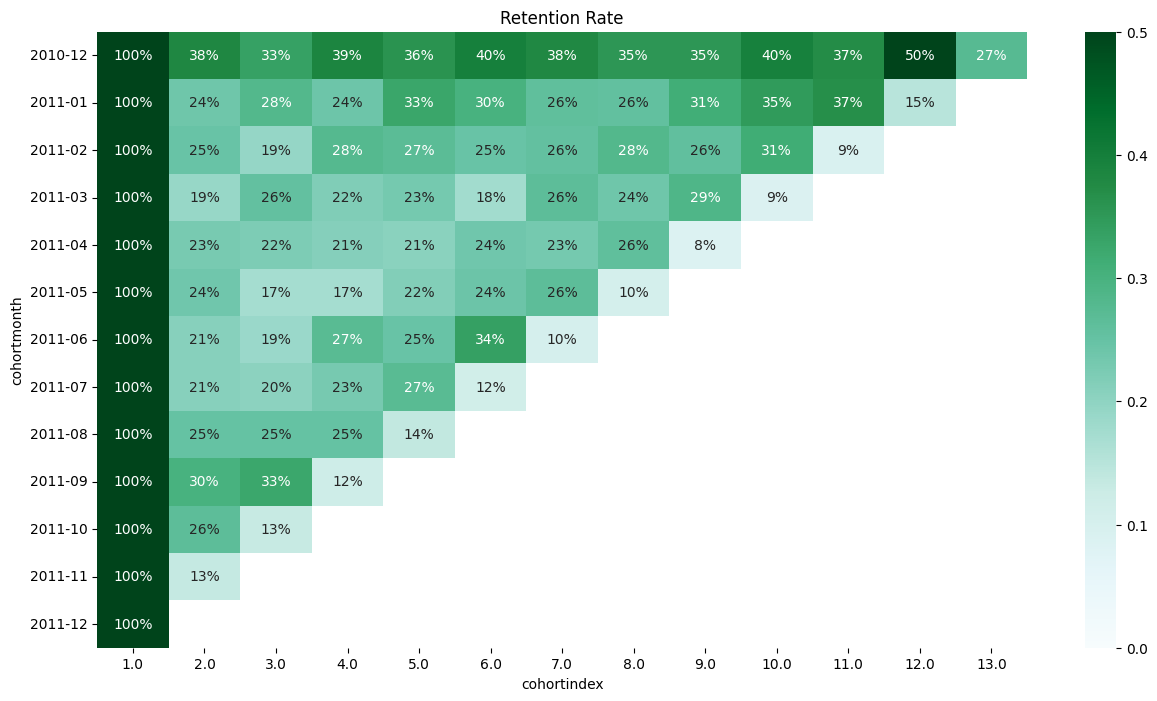

In [20]:
# visualize with heatmap
import matplotlib.pyplot as plt
import seaborn as sns
retention.index = retention.index.strftime('%Y-%m')
plt.figure(figsize=(15, 8))
plt.title('Retention Rate')
sns.heatmap(data=retention, annot=True, fmt='.0%', vmin=0.0, vmax=0.5, cmap='BuGn')
plt.show()